# Topic Modelling - Notes and Playground
(July 06, 2019)

Instead of creating a formal Lit. Review, I would like to learn as much as needed to apply high level concepts for topic modelling. This will start by digging into blogs which utilize standard Python libraries and then push into more in-depth articles, papers, etc. regarding better implementation.

## Table of Contents

1. ["Applying Machine Learning to Classify an Unsupervised Text Documents"](#1)
    * Data -> TD-IDF -> K-means
    
2. ["pyLDAvis - Library for Interactive Topic Model Visualization"](#2)
    * Port of an R package
    
3. ["LDA in Python - How to Grid Search Best Topic Models"](#3)

4. ["Unsupervised LDA to Semi-Supervised GuidedLDA"](#4)

5. [""](#5)

6. ["Playground"](#6)

## Import Libraries and Data

In [79]:
# Imports

# Standard Libraries
from itertools import combinations

# Numerical Libraries
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Visual Libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from IPython.display import Image

# Local Package Libraries
import sys
sys.path.append("../..")

from src.data.make_dataset import *
from src.features.general_helper_functions import *
from src.features.text_cleaning import *

In [80]:
# Settings

# Stop the warnings for chain in pandas...
pd.options.mode.chained_assignment = None

pd.set_option('display.max_colwidth', 1000)

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
# raw data import
_, watchlist_raw, stock_prices_raw = get_raw_data()
article_raw = clean_and_open_business_wire_data_01(None)

In [82]:
# Base data cleaning and formatting
articles = article_raw.copy()
articles.reset_index(inplace=True)
articles.time = pd.to_datetime(articles.time)

watchlist = watchlist_raw.copy()

<a id="1"></a>
## Applying Machine Learning to Classify an Unsupervised Text Documents

* Author builds a model to classify a data set into 2 classifications.
* Steps:
    1. Vectorize the text data by using sklearn's TfidfVectorizer
    2. Implements sklearn's KMeans cluster algorithm with true_k = 2
* The input document is a list of strings, by the appearance the strings are already relatively clean.

In [5]:
# Import
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [6]:
titles_cleaned = clean_text(articles, "title").title.values

In [7]:
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(titles_cleaned)

print(X.shape)

(8433, 8799)


In [8]:
true_num_topics=3 # Obviously not true, but I will go with it for now

naive_kmeans_topic_model = KMeans(
    n_clusters=true_num_topics, 
    init="k-means++", 
    max_iter=100, 
    n_init=1)

naive_kmeans_topic_model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=3, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Can now take a look at the top words in each centroid:

In [9]:
order_centroids = naive_kmeans_topic_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(true_num_topics):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(" %s" % terms[ind])
    print("\n")

Cluster 0:
 announce
 investor
 conference
 present
 healthcare
 pharmaceutical
 board
 therapeutic
 annual
 director


Cluster 1:
 market
 researchandmarkets
 com
 global
 pipeline
 research
 review
 forecast
 analysis
 drug


Cluster 2:
 quarter
 result
 financial
 report
 fourth
 year
 second
 announce
 fiscal
 pharmaceutical




<a id="2"></a>
## pyLDAvis - Library for Interactive Topic Model Visualization
https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=1&lambda=0.5&term=

pyLDAvis is a library that ports an R script for topic visualization.

It is possible to oberlay it with gensim and sklearn.

**pyLDAvis**
https://pyldavis.readthedocs.io/en/latest/

**Gensim's LDA**
https://radimrehurek.com/gensim/models/ldamodel.html

In [7]:
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.tfidfmodel import TfidfModel
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [8]:
tokenized_titles_cleaned = [remove_short_words(text).split(" ") for text in titles_cleaned]
dictionary = corpora.Dictionary(tokenized_titles_cleaned)
dictionary.filter_extremes(no_below=5, no_above=0.4)

In [9]:
corpus = [dictionary.doc2bow(text) for text in tokenized_titles_cleaned]

In [10]:
tfidf_corpus = TfidfModel(corpus)[corpus]

In [12]:
lda = LdaModel(tfidf_corpus, num_topics=40)

In [15]:
for topic_id in range(4):
    print("Topic:", topic_id)
    print([(dictionary[item[0]], np.round(item[1],3)) for item in lda.get_topic_terms(topic_id)], "\n")

Topic: 0
[('life', 0.094), ('science', 0.088), ('celebrate', 0.046), ('launch', 0.034), ('hypertension', 0.029), ('arterial', 0.029), ('pulmonary', 0.026), ('beam', 0.023), ('strengthen', 0.022), ('university', 0.022)] 

Topic: 1
[('year', 0.065), ('fourth', 0.056), ('result', 0.053), ('quarter', 0.053), ('full', 0.047), ('financial', 0.042), ('dystrophy', 0.04), ('muscular', 0.037), ('call', 0.033), ('report', 0.03)] 

Topic: 2
[('diagnostics', 0.064), ('molecular', 0.05), ('previously', 0.047), ('infectious', 0.041), ('strategy', 0.038), ('guide', 0.031), ('leader', 0.03), ('oncology', 0.03), ('researchandmarkets', 0.026), ('global', 0.026)] 

Topic: 3
[('insight', 0.051), ('name', 0.041), ('agreement', 0.04), ('generation', 0.034), ('sequence', 0.032), ('pipeline', 0.031), ('license', 0.03), ('researchandmarkets', 0.03), ('next', 0.029), ('european', 0.028)] 



In [13]:
pyLDAvis.gensim.prepare(lda, tfidf_corpus, dictionary)

c:\users\michael\documents\projects and portfolio work\biopharmaceuticalfactormodel\venv\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18    -0.145057  0.016612       1        1  4.834666
20    -0.199299 -0.013308       2        1  3.979597
27    -0.209887 -0.017859       3        1  3.486433
29    -0.192395 -0.027965       4        1  3.245063
5      0.141039  0.259784       5        1  3.140583
15     0.086845 -0.045151       6        1  2.945106
10     0.141822 -0.155180       7        1  2.838599
19    -0.106263  0.047196       8        1  2.784434
31     0.045572 -0.042379       9        1  2.743544
3     -0.126793 -0.013691      10        1  2.715599
1      0.189210 -0.170754      11        1  2.709132
4      0.131511  0.137474      12        1  2.597458
21     0.053325 -0.017854      13        1  2.518127
26    -0.105525 -0.001407      14        1  2.492375
9      0.058773 -0.047122      15        1  2.481640
32     0.159958 -0.193329      16        1  2.471990
2     -0.086622 -0.012439      17        1  2.460293
36    -0.091308 -0.033120      18        1  2.431709
39    -0.024878 -0.036315      19        1  2.430922
17     0.049829  0.158561      20        1  2.416550
6     -0.106059 -0.055352      21        1  2.398760
23     0.065978  0.184163      22        1  2.391955
24    -0.043452 -0.000190      23        1  2.390729
8      0.116290 -0.171786      24        1  2.380479
35    -0.103900 -0.046846      25        1  2.327824
33    -0.004636  0.155386      26        1  2.325901
28     0.134625  0.184070      27        1  2.211408
37    -0.071821 -0.024103      28        1  2.209456
38     0.046768 -0.131028      29        1  2.166589
34    -0.002509 -0.031099      30        1  2.160236
12    -0.026591  0.032814      31        1  2.058504
11     0.076405  0.113299      32        1  2.056616
0     -0.038213 -0.040202      33        1  2.044191
14     0.029322  0.014603      34        1  1.977696
30    -0.028631  0.031076      35        1  1.977599
25     0.145281 -0.031747      36        1  1.940492
22     0.169976 -0.035019      37        1  1.909798
7      0.031595  0.043002      38        1  1.859562
13    -0.080772 -0.002982      39        1  1.818715
16    -0.079513  0.020185      40        1  1.669662, topic_info=     Category        Freq                Term       Total  loglift  logprob
46    Default  157.000000             quarter  157.000000  30.0000  30.0000
16    Default  174.000000             results  174.000000  29.0000  29.0000
44    Default  135.000000           financial  135.000000  28.0000  28.0000
47    Default  111.000000             reports  111.000000  27.0000  27.0000
177   Default   88.000000                firm   88.000000  26.0000  26.0000
320   Default   81.000000             insight   81.000000  25.0000  25.0000
51    Default   83.000000               board   83.000000  24.0000  24.0000
92    Default   81.000000                year   81.000000  23.0000  23.0000
160   Default  102.000000           investors  102.000000  22.0000  22.0000
745   Default   45.000000               ipsen   45.000000  21.0000  21.0000
314   Default   60.000000                life   60.000000  20.0000  20.0000
52    Default   70.000000           directors   70.000000  19.0000  19.0000
90    Default   60.000000              fourth   60.000000  18.0000  18.0000
45    Default   95.000000               first   95.000000  17.0000  17.0000
212   Default   89.000000            investor   89.000000  16.0000  16.0000
933   Default   47.000000             imaging   47.000000  15.0000  15.0000
315   Default   60.000000            sciences   60.000000  14.0000  14.0000
41    Default  236.000000            pipeline  236.000000  13.0000  13.0000
269   Default   70.000000       investigation   70.000000  12.0000  12.0000
2     Default  112.000000          conference  112.000000  11.0000  11.0000
70    Default   68.000000             officer   68.000000  10.0000  10.0000
202   Default   57.000000              behalf   57.000000  

<a id="3"></a>
## LDA Python - How to Grid Search Best Topic Models

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

<a id="4"></a>
## Unsupervised LDA to Semi-Supervised GuidedLDA

https://www.freecodecamp.org/news/how-we-changed-unsupervised-lda-to-semi-supervised-guidedlda-e36a95f3a164/

## Topic Modelling Metrics

### Cluster Analysis
https://en.wikipedia.org/wiki/Cluster_analysis

#### Internal Evaluation
* Evaluation based on the data that was clustered itself
* Score high when there is high similarity within a cluster and low similarity between clusters
* Drawbacks:
    * High score on an internal measure do not necessarily result in effective information retrieval applications
    * Evaluation is biased toward algos that use the same cluster model

Note: LDA is technically not a clustering algorithm. It instead uses probability distributions. BUT as seen in the LDA visualization above, we can technically consider there to be clusters too. The definition of different clusters simply needs to be made discreet.

**SKlearn has various metrics for clustering algorithms.**

What we would be looking for are the unsupervised metrics such as:
* Silhouette Coefficient
    * best value is 1, worst is -1. 0 implies overlapping clusters
    * sklearn.metrics.silhouette_score(X(nsamples, nfeatures), labels)
* Calinski-Harabasz Index
    * Larger score is better
    * sklearn.metrics.calinski_harabasz_score(X(nsamples, nfeatures), labels)
* Davis-Bouldin Index
    * 0 is the lowest and best score. Closer to zero, the better
    * sklearn.metrics.davies_bouldin_score(X(nsamples, nfeatures), labels)

### Determining the Number of Clusters

https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set

* Rate Distortion Theory

<a id="6"></a>
## Playground

In [11]:
from sklearn.metrics import *
import operator

### Finding the Best Number of Topics

For each of the SKLearn internal clustering metrics, I will try to find the "best" number of topics. Then, using that number, apply LDA to get the topic probabilities. Lastly, manually check some random articles to see how the model does.

To use SKLearn's silhouette_avg, need to predict the labels associated for each document. The classification vector goes in as the "label" input and the data goes in as the X.

In [12]:
def get_best_labels(model, corp):
    return [np.array([tuple_[1] for tuple_ in model.get_document_topics(doc)]).argmax() for doc in corp]

In [19]:
# Settings
max_N = 30
min_N = 3

# Initialize result holder
sill_results = {"best_model": None, "best_model_n": None, "best_score": -1.0}
cal_har_results = {"best_model": None, "best_model_n": None, "best_score": -np.inf}
dav_bou_results = {"best_model": None, "best_model_n": None, "best_score": np.inf}

# Set the data to match formatting in SciKit Learn
num_docs = 8433
X = gensim.matutils.corpus2dense(tfidf_corpus, num_docs)

for model_n in range(min_N, max_N):
    lda_n = LdaModel(tfidf_corpus, model_n)
    
    best_labels = get_best_labels(lda_n, tfidf_corpus)
    
    sil_score = silhouette_score(X, best_labels)
    if sil_score > sill_results["best_score"]:
        sill_results["best_model"] = lda_n
        sill_results["best_model_n"] = model_n
        sill_results["best_score"] = sil_score
        
    cal_score = calinski_harabasz_score(X, best_labels)
    if cal_score > cal_har_results["best_score"]:
        cal_har_results["best_model"] = lda_n
        cal_har_results["best_model_n"] = model_n
        cal_har_results["best_score"] = cal_score
        
    dav_score = davies_bouldin_score(X, best_labels)
    if dav_score < dav_bou_results["best_score"]:
        dav_bou_results["best_model"] = lda_n
        dav_bou_results["best_model_n"] = model_n
        dav_bou_results["best_score"] = dav_score

KeyboardInterrupt: 

In [ ]:
print(sill_results)
print(cal_har_results)
print(dav_bou_results)

In [13]:
class NumTopicsScoreHolder:
    def __init__(self, metric_func, score_relation_direction=">"):
        self.metric_func = metric_func
        self.score_function = {">": operator.gt, "<": operator.lt}[score_relation_direction]
        
        self.score_df = pd.DataFrame(columns=["score", "model"])
        
    def update(self, X, model, n, labels):
        self.score_df = pd.concat([self.score_df, pd.DataFrame({"score": self.metric_func(X, labels), "model": model}, index=[n])])
        
    def get_best_model(self):
        indx = {operator.gt: 0, operator.lt: -1}[self.score_function]
        return self.score_df.sort_values("score", ascending=False).iloc[indx].model

In [17]:
# Settings
max_N = 10
min_N = 2

# Initialize result holder
sill_results = NumTopicsScoreHolder(silhouette_score, ">")
cal_har_results = NumTopicsScoreHolder(calinski_harabasz_score, ">")
dav_bou_results = NumTopicsScoreHolder(davies_bouldin_score, "<")

# Set the data to match formatting in SciKit Learn
num_docs = 8433
X = gensim.matutils.corpus2dense(tfidf_corpus, num_docs)

for model_n in range(min_N, max_N):
    lda_n = LdaModel(tfidf_corpus, model_n)
    
    best_labels = get_best_labels(lda_n, tfidf_corpus)
    
    sill_results.update(X, lda_n, model_n, best_labels)
    cal_har_results.update(X, lda_n, model_n, best_labels)
    dav_bou_results.update(X, lda_n, model_n, best_labels)

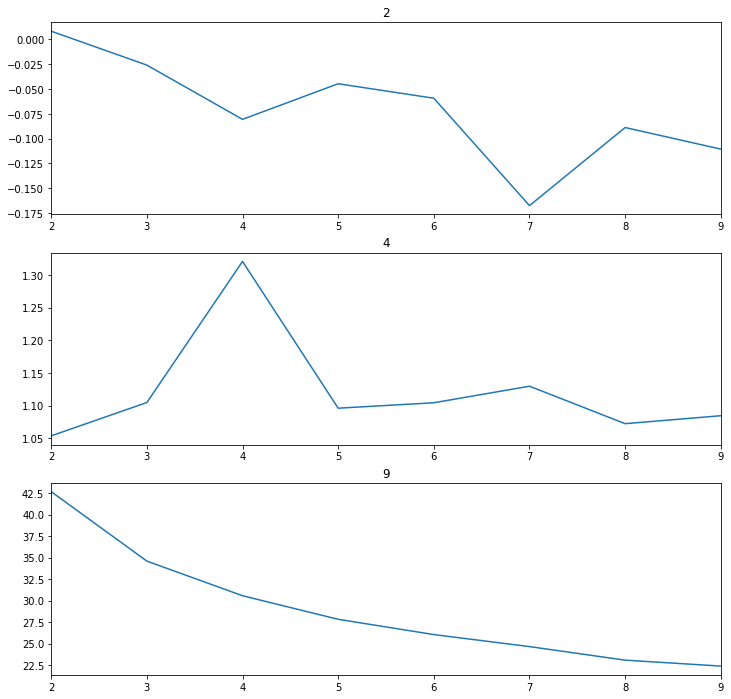

In [18]:
fig, ax = plt.subplots(3, figsize=(12, 12))

ax[0].set_title(sill_results.get_best_model().num_topics)
sill_results.score_df.score.plot(ax=ax[0])

ax[1].set_title(cal_har_results.get_best_model().num_topics)
cal_har_results.score_df.score.plot(ax=ax[1])

ax[2].set_title(dav_bou_results.get_best_model().num_topics)
dav_bou_results.score_df.score.plot(ax=ax[2])

From here, I would like to start taking a look at price statistics for each topic.

To do so I will need to:
1. Seperate the articles into their respective predicted labels
2. Using functionality from previous notebooks, get the window of prices after each event
3. Apply a set of statistics on the prices, and their returns over the window

In [15]:
# Clean price data and get the returns window
prices_df = clean_and_format_prices(stock_prices_raw, articles.ticker.unique())

# Return Window
return_window = compute_return_window(articles, prices_df, n_window=30)

return_window.sort_index().head()

,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,R_10,...,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_29,R_30
0,0.016568,-0.017357,0.019329,0.012229,0.010651,0.008679,0.011045,-0.042998,0.002761,0.022880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.010794,-0.035081,-0.065921,-0.015420,-0.030840,-0.023130,0.000771,0.007710,-0.052043,-0.040093,...,-0.064765,-0.020046,-0.000386,0.026214,-0.008096,0.002313,NaN,NaN,NaN,NaN
3,0.013173,0.006587,0.001162,-0.045719,-0.008136,0.005037,-0.005812,-0.030221,-0.061217,-0.010461,...,-0.034870,0.001162,-0.005812,-0.007361,-0.009299,-0.006974,-0.060054,-0.015110,0.004649,0.031383
4,0.040000,0.050588,0.012157,0.025490,0.018824,0.013333,-0.034118,0.003922,0.017255,0.006275,...,-0.043529,-0.005882,0.010588,-0.023137,0.013333,0.006275,0.004706,0.002745,0.005098,-0.048627


In [16]:
def sharpe_ratio(mean, dev, holding_period, annual_risk_free_rate):
    scale_param = 252 / holding_period # This will be used to annualize the expected return 
                                       # and the deviation
    num = (scale_param * mean - annual_risk_free_rate) 
    den = (np.sqrt(scale_param) * dev)
    return num / den


def downside_deviation(series):
    mean = series.mean()
    shifted_series = series - mean
    neg_values = shifted_series.loc[shifted_series < 0]
    neg_var = (neg_values ** 2).sum() / neg_values.shape[0]
    return np.sqrt(neg_var)


def sortino_ratio(series, holding_period, annual_risk_free_rate):
    scale_param = 252 / holding_period # This will be used to annualize the expected return 
                                       # and the deviation
    num = (scale_param * series.mean() - annual_risk_free_rate) 
    den = (np.sqrt(scale_param) * downside_deviation(series))
    return num / den
    

def report_statistics(series):
    risk_free_rate  = 0.025
    num_days = 30
    
    mean = np.mean(series)
    dev = np.std(series)
    downside_dev = downside_deviation(series)
    skew_ = skew(series)
    kurt_ = kurtosis(series)
    
    sharpe_ratio_ = sharpe_ratio(mean, dev, num_days, risk_free_rate)
    sortino_ratio_ = sortino_ratio(series, num_days, risk_free_rate)
    
    print_statement = """
    STATISTICAL REPORT:
        If held for {} days, the returns for the topic had the following statistics:
        * mean = {}
        * standard deviation = {}
        * downside deviation = {}
        * skew = {}
        * kurtosis = {}
        
        Sharpe Ratio = {}
        Sortino Ratio = {}
    """. format(np.round(num_days, 4), np.round(mean, 4), np.round(dev, 4), np.round(downside_dev, 4), np.round(skew_, 4),
                np.round(kurt_, 4), np.round(sharpe_ratio_, 4), np.round(sortino_ratio_, 4))
    
    return print_statement

**Best Model Using the Sillhouette Coefficient**

In [21]:
sill_article_df = articles.copy()

sill_article_df["labels"] = get_best_labels(sill_results.get_best_model(), tfidf_corpus)

for topic in range(sill_results.get_best_model().num_topics):
    
    articles_in_topic = sill_article_df.loc[sill_article_df.labels == topic]
    
    returns_in_topic = return_window.loc[articles_in_topic.index].dropna()
    
    statement = report_statistics(returns_in_topic["R_30"])
    print("Topic {}".format(topic), "\n", "-"*30)
    print(statement)
    print("\n\n")

Topic 0 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0194
        * standard deviation = 0.2049
        * downside deviation = 0.1694
        * skew = 1.4682
        * kurtosis = 8.3624
        
        Sharpe Ratio = 0.2326
        Sortino Ratio = 0.2813
    



Topic 1 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0213
        * standard deviation = 0.2262
        * downside deviation = 0.1744
        * skew = 1.9632
        * kurtosis = 10.8375
        
        Sharpe Ratio = 0.2347
        Sortino Ratio = 0.3044
    





In [22]:
ch_article_df = articles.copy()

ch_article_df["labels"] = get_best_labels(cal_har_results.get_best_model(), tfidf_corpus)

for topic in range(cal_har_results.get_best_model().num_topics):
    
    articles_in_topic = ch_article_df.loc[ch_article_df.labels == topic]
    
    returns_in_topic = return_window.loc[articles_in_topic.index].dropna()
    
    statement = report_statistics(returns_in_topic["R_30"])
    print("Topic {}".format(topic), "\n", "-"*30)
    print(statement)
    print("\n\n")

Topic 0 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0179
        * standard deviation = 0.2106
        * downside deviation = 0.1746
        * skew = 1.4897
        * kurtosis = 8.6192
        
        Sharpe Ratio = 0.2048
        Sortino Ratio = 0.2471
    



Topic 1 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0218
        * standard deviation = 0.2275
        * downside deviation = 0.1775
        * skew = 1.8197
        * kurtosis = 9.3734
        
        Sharpe Ratio = 0.2398
        Sortino Ratio = 0.3073
    



Topic 2 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0225
        * standard deviation = 0.2096
        * downside deviat

In [23]:
db_article_df = articles.copy()

db_article_df["labels"] = get_best_labels(dav_bou_results.get_best_model(), tfidf_corpus)

for topic in range(dav_bou_results.get_best_model().num_topics):
    
    articles_in_topic = db_article_df.loc[db_article_df.labels == topic]
    
    returns_in_topic = return_window.loc[articles_in_topic.index].dropna()
    
    statement = report_statistics(returns_in_topic["R_30"])
    print("Topic {}".format(topic), "\n", "-"*30)
    print(statement)
    print("\n\n")

Topic 0 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0274
        * standard deviation = 0.2335
        * downside deviation = 0.1818
        * skew = 1.2068
        * kurtosis = 3.5148
        
        Sharpe Ratio = 0.3029
        Sortino Ratio = 0.389
    



Topic 1 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0197
        * standard deviation = 0.173
        * downside deviation = 0.1506
        * skew = 0.7099
        * kurtosis = 1.2817
        
        Sharpe Ratio = 0.2808
        Sortino Ratio = 0.3226
    



Topic 2 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0136
        * standard deviation = 0.199
        * downside deviation

Now, for the next steps, I think what might be interested is using the sharpe ratio and sortino ratio as the metric for determining the number of topics.

Could take a look at that tomorrow.

## An Overview of Topic Extraction in Python with LDA

https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc

### Data Cleaning
* A common thing you will encounter with LDA is that words appear in multiple topics. One way to cope with this is to add these words to your stopwords list.

### Data Preperation (Feature Engineering)
* Include bi- and tri-grams to grasp more relevant information.

* Another classic preparation step is to use only nouns and verbs using POS tagging (POS: Part-Of-Speech).
    * https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b

### Fine Tuning
* Cleaning your data: adding stop words that are too frequent in your topics and re-running your model is a common step. Keeping only nouns and verbs, removing templates from texts, testing different cleaning methods iteratively will improve your topics. Be prepared to spend some time here.
* Alpha, Eta. If you’re not into technical stuff, forget about these. Otherwise, you can tweak alpha and eta to adjust your topics. Start with ‘auto’, and if the topics are not relevant, try other values. I recommend using low values of Alpha and Eta to have a small number of topics in each document and a small number of relevant words in each topic.
* Increase the number of passes to have a better model. 3 or 4 is a good number, but you can go higher.

### Assessing Results
* Are your topics interpretable?
* Are your topics unique? (two different topics have different words)
* Are your topics exhaustive? (are all your documents well represented by these topics?)

## Accounting for noise when clustering biological data

https://academic.oup.com/bib/article/14/4/423/192812

## Updated Text Pre-processing

(July 8, 2019)

In [14]:
from nltk import word_tokenize, pos_tag

NOTE: Need to change this slightly! pos_tag is used twice!

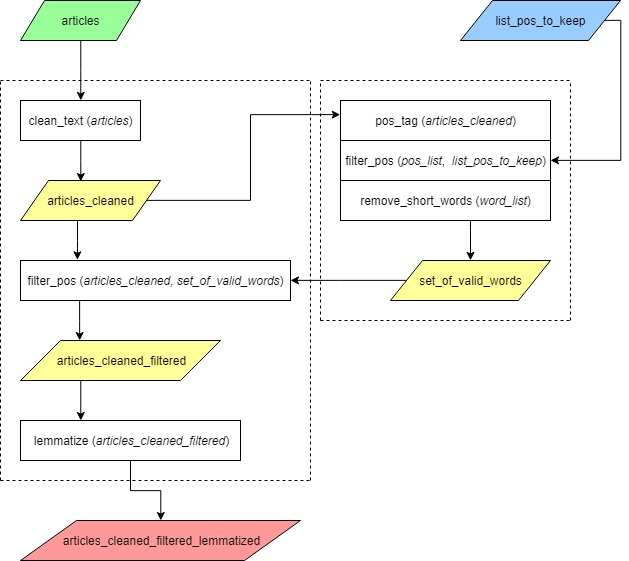

In [24]:
Image("../../reports/figures/TextCleaningPipeline_TopicModelling.jpg", width=600)

In [15]:
def filter_pos_from_word_list(pos_list, list_pos_to_keep):
    return [tuple_[0] for tuple_ in pos_list if tuple_[1] in list_pos_to_keep]

def text_filter(texts, list_pos_to_keep):
    merged_text = " ".join(texts.values.tolist())
    
    pos_list = pos_tag(word_tokenize(merged_text))
    
    word_list = filter_pos_from_word_list(pos_list, list_pos_to_keep)
    
    return [word for word in word_list if len(word) >= 4]

def filter_pos_from_text(text, set_valid_words):
    return " ".join([word for word in word_tokenize(text) if word in set_valid_words])

In [16]:
list_pos_to_keep = [
    "NN", "NNS", "NNP", "NNPS", 
    "VB", "VBD", "VBG", "VBN", "VBP", "VBZ", 
    "JJ", "JJR", "JJS", "RB", "RBR", "RBS"
]

In [17]:
list_of_company_names = watchlist.index.tolist()

In [18]:
articles_cleaned = clean_text(articles, "title").title

valid_words = text_filter(articles_cleaned, list_pos_to_keep)

articles_final = (articles_cleaned.apply(filter_pos_from_text, args=(valid_words,))
                  .apply(lemmatize_text)
                  .apply(remove_company_name, args=(list_of_company_names,))
                 )

gridspecs:
https://towardsdatascience.com/a-step-by-step-guide-for-creating-advanced-python-data-visualizations-with-seaborn-matplotlib-1579d6a1a7d0

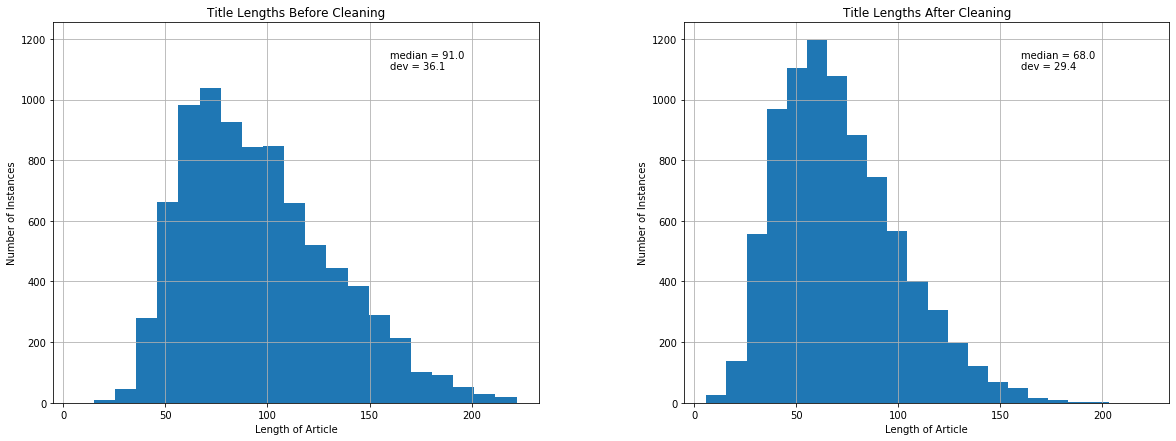

In [19]:
fig = plt.figure(figsize=(20,7))

gs = gridspec.GridSpec(nrows=1, ncols=2, figure=fig, width_ratios=[1, 1], wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0], title="Title Lengths Before Cleaning", xlabel="Length of Article", ylabel="Number of Instances")
ax1_text = "median = {}\ndev = {}".format(np.round(articles.title.apply(len).median(), 1), np.round(articles.title.apply(len).std(), 1))
ax1.text(160, 1100, ax1_text)
articles.title.apply(len).hist(bins=20, ax=ax1)

ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1, title="Title Lengths After Cleaning", xlabel="Length of Article", ylabel="Number of Instances")
ax2_text = "median = {}\ndev = {}".format(np.round(articles_final.apply(len).median(), 1), np.round(articles_final.apply(len).std(), 1))
ax2.text(160, 1100, ax2_text)
_ = articles_final.apply(len).hist(bins=20, ax=ax2)

### Run Through LDA Modelling

In [20]:
tokenized_titles_cleaned = [text.split(" ") for text in articles_final]
dictionary = corpora.Dictionary(tokenized_titles_cleaned)
dictionary.filter_extremes(no_below=5, no_above=0.4)

corpus = [dictionary.doc2bow(text) for text in tokenized_titles_cleaned]

tfidf_corpus = TfidfModel(corpus)[corpus]

In [33]:
# Settings
max_N = 20
min_N = 4

# Initialize result holder
cal_har_results = NumTopicsScoreHolder(calinski_harabasz_score, ">")

# Set the data to match formatting in SciKit Learn
num_docs = 8433
X = gensim.matutils.corpus2dense(tfidf_corpus, num_docs)

for model_n in range(min_N, max_N):
    lda_n = LdaModel(tfidf_corpus, model_n, passes=10, iterations=300)
    
    best_labels = get_best_labels(lda_n, tfidf_corpus)
    
    cal_har_results.update(X, lda_n, model_n, best_labels)

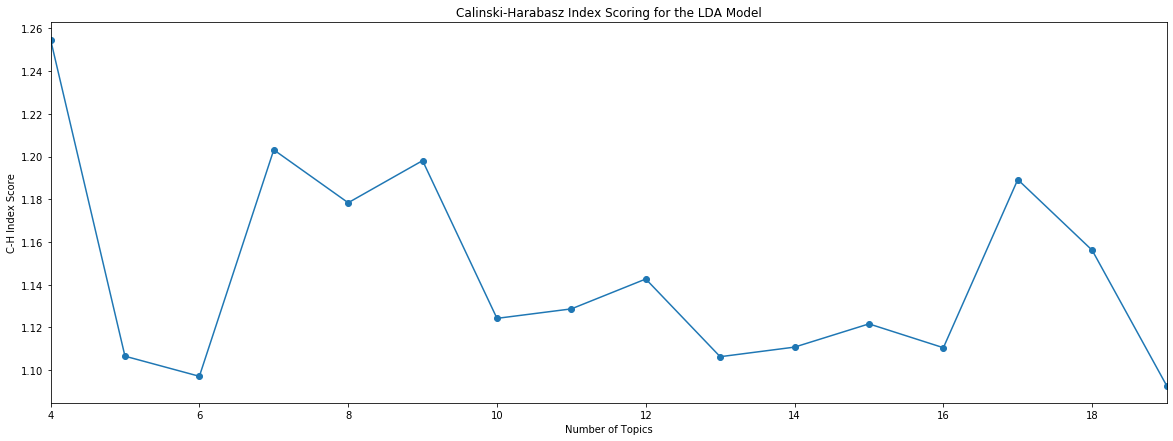

In [34]:
fig = plt.Figure(figsize=(20, 7))

ax = fig.add_subplot(title="Calinski-Harabasz Index Scoring for the LDA Model", xlabel="Number of Topics", ylabel="C-H Index Score")

best_num = title=cal_har_results.get_best_model().num_topics

cal_har_results.score_df.score.plot(marker='o', ax=ax)

fig

### Visually Check the Results of Some of the Top Scoring Models

In [91]:
def get_top_n_words_in_topic(model, topic, gensim_dict, topn=10):
    return [gensim_dict[tuple_[0]] for tuple_ in model.get_topic_terms(topic, topn)]

In [92]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def highlight_word(s, word_list):
    '''
    highlight the maximum in a Series yellow.
    '''
    colors = sns.light_palette("purple", n_colors=len(word_list)).as_hex()
    df = s.copy()
    df.loc[~df.isin(word_list)] = ""
    for i, word in enumerate(word_list):
        df.loc[df == word] = "background-color: {}".format(colors[i])
    return df#['background-color: yellow' if v else '' for v in is_in_list]

In [124]:
model = cal_har_results.score_df.loc[7].model

pyLDAvis.gensim.prepare(model, tfidf_corpus, dictionary)

c:\users\michael\documents\projects and portfolio work\biopharmaceuticalfactormodel\venv\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.257474  0.070629       1        1  19.399189
3     -0.253428  0.095410       2        1  16.375988
0      0.045550 -0.157757       3        1  16.369701
1      0.229386  0.302303       4        1  12.818052
4      0.121182 -0.157231       5        1  12.627756
6      0.123523 -0.015728       6        1  11.445152
5     -0.008741 -0.137627       7        1  10.964161, topic_info=     Category        Freq                Term       Total  loglift  logprob
38    Default  183.000000             quarter  183.000000  30.0000  30.0000
11    Default  195.000000              result  195.000000  29.0000  29.0000
33    Default  219.000000            pipeline  219.000000  28.0000  28.0000
35    Default  186.000000              review  186.000000  27.0000  27.0000
36    Default  151.000000           financial  151.000000  26.0000  26.0000
1     Default  145.000000          conference  145.000000  25.0000  25.0000
3     Default  129.000000             present  129.000000  24.0000  24.0000
119   Default  315.000000              market  315.000000  23.0000  23.0000
142   Default  150.000000            investor  150.000000  22.0000  22.0000
34    Default  252.000000  researchandmarkets  252.000000  21.0000  21.0000
39    Default  233.000000              report  233.000000  20.0000  20.0000
322   Default  173.000000            forecast  173.000000  19.0000  19.0000
37    Default  108.000000               first  108.000000  18.0000  18.0000
31    Default  114.000000             insight  114.000000  17.0000  17.0000
157   Default   78.000000                firm   78.000000  16.0000  16.0000
135   Default   74.000000               alert   74.000000  15.0000  15.0000
81    Default   85.000000                year   85.000000  14.0000  14.0000
117   Default  130.000000                drug  130.000000  13.0000  13.0000
164   Default  155.000000            analysis  155.000000  12.0000  12.0000
138   Default   67.000000               class   67.000000  11.0000  11.0000
79    Default   65.000000              fourth   65.000000  10.0000  10.0000
105   Default   64.000000               third   64.000000   9.0000   9.0000
129   Default   92.000000             profile   92.000000   8.0000   8.0000
43    Default   96.000000               board   96.000000   7.0000   7.0000
428   Default   91.000000               trend   91.000000   6.0000   6.0000
134   Default   68.000000              action   68.000000   5.0000   5.0000
236   Default   59.000000       investigation   59.000000   4.0000   4.0000
45    Default   90.000000            director   90.000000   3.0000   3.0000
242   Default   52.000000            upcoming   52.000000   2.0000   2.0000
42    Default   87.000000             appoint   87.000000   1.0000   1.0000
...       ...         ...                 ...         ...      ...      ...
433    Topic7   11.530625              anemia   12.305194   2.1455  -5.2777
1232   Topic7   11.355313               kirby   12.132296   2.1444  -5.2931
1233   Topic7   11.355313           mcinerney   12.132296   2.1444  -5.2931
639    Topic7   11.187101             veteran   11.961321   2.1436  -5.3080
550    Topic7   11.359659              boston   12.150393   2.1432  -5.2927
1059   Topic7   11.034957             sponsor   11.810031   2.1427  -5.3217
1442   Topic7   10.929822          electronic   11.704271   2.1421  -5.3313
214    Topic7   10.633860            provider   11.408699   2.1402  -5.3587
583    Topic7   10.119897            contract   10.894132   2.1368  -5.4083
473    Topic7   10.109506                beam   10.886285   2.1365  -5.4093
1443   Topic7    9.925123              dental   10.699586   2.1354  -5.4277
923    Topic7   10.475567            invasive   11.299500   2.1348  -5.3737
421    Topic7   28.007290                team   32.560013   2.0599  -4.3903
827    Topic7   20.804474          innovation   29.

In [125]:
num_topics = model.num_topics
num_keywords = 15

top_words_df = pd.DataFrame({"topic_{}".format(n+1): get_top_n_words_in_topic(model, n, dictionary, num_keywords) for
                             n in range(num_topics)}, index=[i for i in range(num_keywords)])

print("Top {} Keywords for Each Topic".format(num_keywords))
words_in_multiple_topics = top_words_df.stack().value_counts().loc[top_words_df.stack().value_counts() > 1].index.tolist()

styled_top_words_df = top_words_df.style.apply(highlight_word, args=(words_in_multiple_topics,))
    
styled_top_words_df

Top 15 Keywords for Each Topic


,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,director,investor,market,pipeline,result,equity,conference
1,announce,firm,researchandmarkets,review,quarter,rosen,present
2,board,alert,forecast,insight,financial,participate,annual
3,appoint,class,analysis,market,report,board,upcoming
4,officer,announce,trend,drug,first,add,investor
5,chief,action,product,researchandmarkets,year,team,north
6,phase,investigation,application,profile,fourth,leadership,morgan
7,patient,file,outlook,therapeutic,third,appointment,america
8,trial,security,device,report,full,announce,dilation
9,president,lawsuit,growth,development,update,state,index


In [126]:
words_in_multiple_topics = top_words_df.stack().value_counts().loc[top_words_df.stack().value_counts() > 1].index.tolist()

print(*words_in_multiple_topics)

announce report board market analysis researchandmarkets investor therapeutic


Now, we can finish off this notebook, and write a nice report with the figures. Would also like to pickle the model for later use.

**YAY**

In [109]:
from src.features.topic_modelling.lda_topic_model_v3 import *
import src

In [110]:
with open("../../src/models/lda_model", "rb") as infile:
    LDA_holder = pickle.load(infile)
    
with open("../../src/models/lda_model_dict", "rb") as infile:
    dictionary = pickle.load(infile)

In [111]:
LDA_holder.models.model_df

,score,model
3,1.587758,"LdaModel(num_terms=621, num_topics=3, decay=0.5, chunksize=2000)"
4,1.305172,"LdaModel(num_terms=621, num_topics=4, decay=0.5, chunksize=2000)"
5,1.199158,"LdaModel(num_terms=621, num_topics=5, decay=0.5, chunksize=2000)"
6,1.426798,"LdaModel(num_terms=621, num_topics=6, decay=0.5, chunksize=2000)"
7,1.327713,"LdaModel(num_terms=621, num_topics=7, decay=0.5, chunksize=2000)"
8,1.303022,"LdaModel(num_terms=621, num_topics=8, decay=0.5, chunksize=2000)"
9,1.226327,"LdaModel(num_terms=621, num_topics=9, decay=0.5, chunksize=2000)"
10,1.213423,"LdaModel(num_terms=621, num_topics=10, decay=0.5, chunksize=2000)"
11,1.137636,"LdaModel(num_terms=621, num_topics=11, decay=0.5, chunksize=2000)"
12,1.152639,"LdaModel(num_terms=621, num_topics=12, decay=0.5, chunksize=2000)"


In [114]:
m = LDA_holder.models.model_df.loc[6].model

num_topics = m.num_topics
num_keywords = 20

top_words_df = pd.DataFrame({"topic_{}".format(n+1): get_top_n_words_in_topic(m, n, dictionary, num_keywords) for
                             n in range(num_topics)}, index=[i for i in range(num_keywords)])

print("Top {} Keywords for Each Topic".format(num_keywords))
words_in_multiple_topics = top_words_df.stack().value_counts().loc[top_words_df.stack().value_counts() > 1].index.tolist()

styled_top_words_df = top_words_df.style.apply(highlight_word, args=(words_in_multiple_topics,))
    
styled_top_words_df

Top 20 Keywords for Each Topic


,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,investor,global,conference,clinical,pipeline,quarter
1,board,strategic,present,trial,review,result
2,director,researchandmarkets,healthcare,phase,researchandmarkets,financial
3,firm,system,chief,patient,research,report
4,alert,therapy,officer,product,global,first
5,announce,business,annual,application,drug,year
6,intersect,agreement,appoint,treatment,insight,announce
7,class,advance,image,type,analysis,third
8,action,epidemiology,appointment,global,forecast,fourth
9,investigation,collaboration,president,forecast,report,second


In [201]:
new_p = PreProcessing()
new_p.fit_from_pickle("../../src/models/lda_model_dict", "../../src/models/lda_model_tfidf_model")

article = articles.sample(10)

test_article = articles.sample(1)
x_test = new_p.transform(test_article, watchlist)
print(x_test[0])

topic = LDA_holder.get_topic(x_test, 6)

print("The topic is: ",topic)

[(12, 0.2619302966059565), (29, 0.30420758395133846), (31, 0.27665245771350866), (32, 0.20675890390301221), (82, 0.41620998037424284), (150, 0.42005789269216876), (185, 0.4385551656787133), (238, 0.42137207378362007)]
The topic is:  [5]


In [144]:
dict_ = {"date": 50, "title": "ACADIA Pharmaceuticals Initiates Phase 3 CLARITY Program with Pimavanserin as Adjunctive Treatment for Major Depressive Disorder"}
a = pd.DataFrame(dict_, index=[0])

x_test = new_p.transform(a, watchlist)

topic = LDA_holder.get_topic(x_test, 6)

print("The topic is: ",topic)

The topic is:  [0]


In [164]:
new_p.transform(articles.sample(1), watchlist).corpus

[[(12, 1), (30, 1), (31, 1), (32, 1), (417, 1), (612, 1)]]

In [147]:
x_test.corpus

[[]]

In [150]:
new_p.tfidf_.dfs

{0: 82,
 1: 314,
 2: 512,
 3: 2069,
 4: 439,
 5: 581,
 6: 449,
 7: 88,
 8: 92,
 9: 49,
 10: 140,
 11: 222,
 12: 720,
 13: 214,
 14: 95,
 15: 579,
 16: 181,
 17: 21,
 18: 94,
 19: 31,
 20: 206,
 21: 242,
 22: 62,
 23: 329,
 24: 404,
 25: 59,
 26: 1368,
 27: 2434,
 28: 946,
 29: 484,
 30: 325,
 31: 627,
 32: 1209,
 33: 58,
 34: 103,
 35: 248,
 36: 304,
 37: 297,
 38: 1335,
 39: 20,
 40: 28,
 41: 62,
 42: 22,
 43: 21,
 44: 70,
 45: 109,
 46: 198,
 47: 122,
 48: 214,
 49: 107,
 50: 20,
 51: 75,
 52: 279,
 53: 74,
 54: 24,
 55: 156,
 56: 93,
 57: 47,
 58: 248,
 59: 40,
 60: 162,
 61: 143,
 62: 238,
 63: 36,
 64: 132,
 65: 26,
 66: 60,
 67: 23,
 68: 96,
 69: 65,
 70: 37,
 71: 74,
 72: 65,
 73: 21,
 74: 135,
 75: 30,
 76: 90,
 77: 21,
 78: 167,
 79: 79,
 80: 79,
 81: 40,
 82: 169,
 83: 30,
 84: 213,
 85: 269,
 86: 91,
 87: 26,
 88: 79,
 89: 42,
 90: 301,
 91: 676,
 92: 403,
 93: 125,
 94: 174,
 95: 130,
 96: 26,
 97: 79,
 98: 20,
 99: 30,
 100: 362,
 101: 331,
 102: 297,
 103: 324,
 104: 180,

So as it appears, the get_topic function does not work for predicting new documents. The reason is that the TF-IDF technically needs to be retrained.

Instead, I will create a transform function to be used with the TF-IDF function that uses the trained document frequency.

given a document:
1. Clean the text
2. Get the BOW using the dictionary
3. Calculate the frequency of each word
4. Calculate IF-IDF

Formula for TF-IDF:

$ weight_{i, j} = frequency_{i, j} * log_2\left( \frac{D}{docfre_i} \right) $

In [159]:
def _clean_text(texts, watchlist):
    # Settings and attributes
    list_pos_to_keep = [
        "NN", "NNS", "NNP", "NNPS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ",
        "JJ", "JJR", "JJS", "RB", "RBR", "RBS"
    ]

    list_of_company_names = watchlist

    # 1. Standard Text Cleaning
    text = clean_text(texts, "title").title
    text = text.apply(str.lower)
    # 2. Filter Part of Speech
    list_pos_to_keep = text_filter(text, list_pos_to_keep)
    text = text.apply(filter_pos_from_text, args=(list_pos_to_keep,))
    # 3. Lemmatize
    text = text.apply(lemmatize_text)
    # 4. Remove company names
    text = text.apply(remove_company_name, args=(list_of_company_names,))

    return text.values

In [204]:
def tf_idf_transform(articles, watchlist, tfidf_model, dictionary):
    cleaned_articles = _clean_text(articles, watchlist)
    tokenized_titles_cleaned = [text.split(" ") for text in cleaned_articles]
    new_corpus = [dictionary.doc2bow(text) for text in tokenized_titles_cleaned]
    
    num_original_documents = dictionary.num_docs

    return [transform_tfidf(corp, tfidf_model.dfs, num_original_documents) for corp in new_corpus]

def transform_tfidf(corp, doc_frequencies, num_original_docs):
    '''
    Notes:
        1. corp is a list of each documents word:frequency pairing
                -> list of a list of tuples
        2. doc_frequencies is a dictionary mapping a word to its document frequency
    '''
    # Convert to list comp. later
    doc_list = []
    for word_pair in corp:
        word = word_pair[0]
        freq = word_pair[1]
        doc_freq = doc_frequencies[word]
        tfidf_pair = (word, tfidf(freq, doc_freq, num_original_docs))
        doc_list.append(tfidf_pair)

    return l2_normalize(doc_list[:])
            

def tfidf(term_frequency, doc_frequency, num_original_docs):
    t1 = term_frequency
    t2 = num_original_docs / doc_frequency
    t3 = np.log2(t2)
    return t1 * t2


def l2_normalize(list_pairs):
    norm_factor = np.sqrt(sum([i[1] ** 2 for i in list_pairs]))
    return [(i[0], i[1] / norm_factor) for i in list_pairs]
        
    

tf_idf_transform(test_article, watchlist, new_p.tfidf_, new_p.dict_)

[[(12, 0.07586766048425048),
  (29, 0.11286098253855442),
  (31, 0.08712075845081395),
  (32, 0.045181733290868775),
  (82, 0.3232231689269843),
  (95, 0.42019011960507957),
  (150, 0.33512095428625976),
  (185, 0.3987205514500755),
  (194, 0.5517648035218217),
  (238, 0.33928394750720714)]]

## Try SKLearn's TF-IDF:

In [280]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [249]:
cleaned_articles = _clean_text(articles.sample(2000), watchlist)

tfidf = TfidfVectorizer(min_df=0.01, max_df=0.4)

X = tfidf.fit_transform(cleaned_articles)

In [250]:
lda = LatentDirichletAllocation(n_components=6)

lda.fit(X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=6, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [252]:
a_transformed = tfidf.transform(_clean_text(a, watchlist))
lda.transform(a_transformed)

array([[0.18595708, 0.04869171, 0.3236543 , 0.04885217, 0.34410333,
        0.0487414 ]])

In [253]:
def get_topic(data, watchlist):
    a_transformed = tfidf.transform(_clean_text(data, watchlist))
    return lda.transform(a_transformed)

In [266]:
dict_ = {"date": 50, "title": "ACADIA Pharmaceuticals to Present at the Bank of America Merrill Lynch Health Care Conference 2019"}
a = pd.DataFrame(dict_, index=[0])

dict_ = {"date": 50, "title": "ACADIA Pharmaceuticals Reports First Quarter 2019 Financial Results"}
b = pd.DataFrame(dict_, index=[0])

dict_ = {"date": 50, "title": "ACADIA Pharmaceuticals Initiates Phase 3 CLARITY Program with Pimavanserin as Adjunctive Treatment for Major Depressive Disorder"}
c = pd.DataFrame(dict_, index=[0])

dict_ = {"date": 50, "title": "KalVista Pharmaceuticals Appoints Daniel B. Soland to Board of Directors"}
d = pd.DataFrame(dict_, index=[0])

In [267]:
for data in [a, b, c, d]:
    print(get_topic(data, watchlist))

[[0.04610034 0.0460994  0.2158591  0.04633435 0.44854717 0.19705964]]
[[0.04644434 0.04644725 0.04643243 0.76696984 0.04723017 0.04647597]]
[[0.18595708 0.04869171 0.3236543  0.04885217 0.34410333 0.0487414 ]]
[[0.05568692 0.0556849  0.0556692  0.05582195 0.05591299 0.72122404]]


Yes, this is much easier to implement than GenSim, I will use this instead for the NewsApp

In [268]:
from src.features.topic_modelling.lda_topic_model_sklearn import *
import src

with open("../../src/models/lda_model_sklearn", "rb") as infile:
    LDA_holder = pickle.load(infile)

In [270]:
for data in [a, b, c, d]:
    print(LDA_holder.get_topic(data, watchlist, 6))

[4]
[2]
[1]
[1]


In [271]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [284]:
dir(LDA_holder.tfidf_model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_char_ngrams',
 '_char_wb_ngrams',
 '_check_params',
 '_check_stop_words_consistency',
 '_check_vocabulary',
 '_count_vocab',
 '_get_param_names',
 '_get_tags',
 '_limit_features',
 '_more_tags',
 '_sort_features',
 '_stop_words_id',
 '_tfidf',
 '_validate_custom_analyzer',
 '_validate_params',
 '_validate_vocabulary',
 '_white_spaces',
 '_word_ngrams',
 'analyzer',
 'binary',
 'build_analyzer',
 'build_preprocessor',
 'build_tokenizer',
 'decode',
 'decode_error',
 'dtype',
 'encoding',
 'fit',
 'fit_transform',
 'fixed_vocabulary_',
 'get_feature_names',
 'get_params',
 'get_stop_words

In [283]:
tf_vectorizer = CountVectorizer(min_df=0.01, max_df=0.4)
tf_vectorizer.fit(_clean_text(articles, watchlist))

pyLDAvis.sklearn.prepare(
    LDA_holder.models.model_df.loc[6].model, 
    X, 
    LDA_holder.
)

AssertionError: Term frequencies and vocabulary are of different sizes, 152 != 144.